In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh
from scipy.special import roots_legendre
from scipy.sparse.linalg import eigs

In [20]:
# Constants
Np = 100
Nphi = 40
pi = np.pi
ONE = 1.0
ZERO = 0.0
Tel_deuteron = 1.0e-10
mass = 1.0
m = 0  # Orbital quantum number (for angular momentum)
n = 0  # Principal quantum number, must be >= m
E_exact = -ONE / (n + 0.5)**2  # Exact energy for comparison
BE2_1 = E_exact * 0.95  # Slightly lower bound for energy estimate
BE2_2 = E_exact * 1.05  # Slightly upper bound for energy estimate

In [21]:
def hyperbolic(Np):
    """
    Generate momentum points and weights using a hyperbolic distribution.
    """
    X, dX = roots_legendre(Np)
    P = (1.0 + X) / (1.0 - X)
    dP = 2.0 / (1.0 - X)**2 * dX
    return P, dP

def linear(Nphi, a, b):
    """
    Generate linearly spaced angular points and weights.
    """
    X, dX = roots_legendre(Nphi)
    x = (b - a) / 2 * X + (b + a) / 2
    dx = (b - a) / 2 * dX
    return x, dx

In [22]:
def compute_V_2B(Np, Nphi, m, p, xp, phi, dphi):
    """
    Compute the potential matrix V_2B and integrate over the angular coordinate phi.
    """
    V_2B = np.zeros((Np, Np, Nphi))
    for ip in range(Np):
        for ipp in range(Np):
            for ixp in range(Nphi):
                q = np.sqrt(p[ip]**2 + p[ipp]**2 - 2 * p[ip] * p[ipp] * xp[ixp])
                V_2B[ip, ipp, ixp] = -1.0 / (q * pi)

    V_2B_2d = np.zeros((Np, Np))
    cos_terms = np.cos(m * phi)
    for ipp in range(Np):
        for ip in range(Np):
            V_2B_2d[ip, ipp] = np.sum(dphi * V_2B[ip, ipp, :] * cos_terms)

    return V_2B_2d

In [23]:
def eigenvalue(Mmatrix):
    """
    This function calculates a few eigenvalues and eigenvectors of the matrix Mmatrix.

    Args:
        Mmatrix (numpy.ndarray): A square matrix from which to find eigenvalues and eigenvectors.

    Returns:
        WF (numpy.ndarray): The eigenvectors corresponding to the largest eigenvalue.
        Lambda (float): The largest eigenvalue.
    """
    # Determine the size of the matrix
    dim_Mmatrix = Mmatrix.shape[0]

    # Specify the number of eigenvalues and eigenvectors to find
    # NEV: number of eigenvalues,
    # NCV: number of Arnoldi vectors, must be greater than NEV
    NEV = 10
    NCV = 2 * NEV # A larger NCV can accelerate convergence
    # Use 'LM' (Largest Magnitude) or 'LR' (Largest Real part) as needed
    WHICH = 'LR'
    # Find NEV eigenvalues with the largest magnitude
    eigenvalues, eigenvectors = eigs(Mmatrix, k=NEV, which=WHICH, ncv=NCV)
    # Target eigenvalue near 1
    target_eigenvalue = 1.0
    idx_min = np.argmin(np.abs(eigenvalues - target_eigenvalue))
    Lambda = eigenvalues[idx_min]
    WF = np.abs(eigenvectors[:, idx_min])

    return WF, Lambda

In [24]:
def LS_2D(Np, pp, dp, V_2B):
    """
    Solve the Lippmann-Schwinger equation in 2D for the given potential matrix.

    Args:
        Np (int): Number of momentum grid points.
        pp (np.ndarray): Array of momentum values, shape (Np,).
        dp (np.ndarray): Differential weights associated with pp, shape (Np,).
        V_2B (np.ndarray): Non-relativistic potential matrix, shape (Np, Np).

    Returns:
        float: The energy eigenvalue closest to the expected bound state energy.
        np.ndarray: Normalized eigenvector corresponding to the computed eigenvalue.
    """
    Ne = 20
    BE_ary = np.zeros(Ne)
    Lam_ary = np.zeros(Ne)
    BE_ary[0] = BE2_1
    BE_ary[1] = BE2_2

    for ie in range(Ne):
        if ie > 1:
            BE_ary[ie] = BE_ary[ie-1] + (1 - Lam_ary[ie-1]) / (Lam_ary[ie-2] - Lam_ary[ie-1]) * (BE_ary[ie-2] - BE_ary[ie-1])
        BE2 = BE_ary[ie]
        Mmatrix = np.zeros((Np, Np))
        for ip in range(Np):
            for ipp in range(Np):
                denom = (BE2 - pp[ip]**2 / mass)
                if denom != 0:
                    Mmatrix[ip, ipp] = dp[ipp] * pp[ipp] * V_2B[ip, ipp] / denom

        WF, Lambda = eigenvalue(Mmatrix)
        WF /= np.sqrt(np.sum(WF**2 * dp * pp))

        Lam_ary[ie] = Lambda
        print(f"Iteration {ie} | BE2 = {BE2}, Lambda = {Lambda}")

        if np.abs(Lambda - 1.0) < Tel_deuteron:
            break

    return BE2, WF

C:\Users\Kayvon\AppData\Local\Temp\ipykernel_21752\174736244.py:35: ComplexWarning: Casting complex values to real discards the imaginary part
  Lam_ary[ie] = Lambda


Iteration 0 | BE2 = -3.8, Lambda = (1.0398196846652865+0j)
Iteration 1 | BE2 = -4.2, Lambda = (0.9892556967381615+0j)
Iteration 2 | BE2 = -4.115004304824029, Lambda = (0.9993796419376192+0j)
Iteration 3 | BE2 = -4.1097960817715276, Lambda = (1.0000101998578528+0j)
Iteration 4 | BE2 = -4.109880329598883, Lambda = (0.9999999871522594+0j)
Iteration 5 | BE2 = -4.109880223613821, Lambda = (1.0000000029116178+0j)
Iteration 6 | BE2 = -4.109880243195075, Lambda = (1.0000000005500909+0j)
Iteration 7 | BE2 = -4.109880247756306, Lambda = (0.9999999999994016+0j)
Final BE2: -4.109880247756306
Exact BE2: -4.0
Rel % Difference: 2.747006193907642


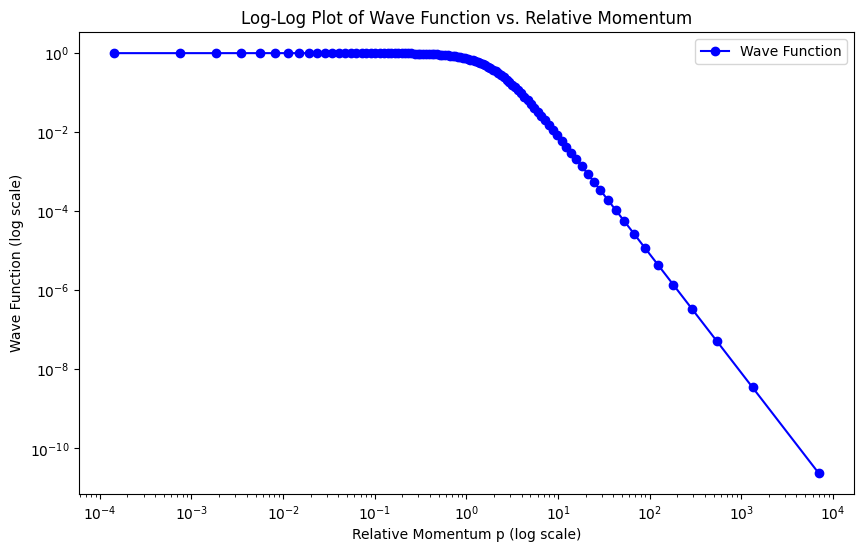

In [25]:
def main():
    """
    Main function to orchestrate the computation and visualization.
    """
    p, dp = hyperbolic(Np)
    phi, dphi = linear(Nphi, 0, 2.0 * pi)
    xp = np.cos(phi)
    V_2B_2d = compute_V_2B(Np, Nphi, m, p, xp, phi, dphi)
    BE2, WF = LS_2D(Np, p, dp, V_2B_2d)
    rel_error = np.abs((BE2 - E_exact) / E_exact) * 100

    print(f'Final BE2: {BE2}')
    print(f'Exact BE2: {E_exact}')
    print(f'Rel % Difference: {rel_error}')

    plt.figure(figsize=(10, 6))
    plt.loglog(p, WF, 'bo-', label='Wave Function')
    plt.xlabel('Relative Momentum p (log scale)')
    plt.ylabel('Wave Function (log scale)')
    plt.title('Log-Log Plot of Wave Function vs. Relative Momentum')
    # plt.grid(True, which="both", ls="--")
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()